### clinvar missense prediction w/ feature intersection
* only use consistent positions
* only missense clinvar
* use positions w/ mpc **OR** pathogenic fraction

In [80]:
import pandas, numpy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from IPython.display import HTML
%matplotlib inline

In [83]:
def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    return pandas.Series([frac, len(rows)], index=['path_frac', 'size'])

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t').fillna(0)
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)
ff = dd.reset_index()

# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if pfam in domain_info:
            if domain_info[pfam][2] == 0:
                ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            if pfam in domain_info:
                return domain_info[pfam]
        
    if len(ls):
        return ls[0]
    else:
        return (0, 0, 1)
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff.values}

df_pre.loc[:, 'path_frac_t'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size_t'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)
df_pre.loc[:, 'in_none_pfam'] = df_pre.apply(lambda row: 1 if 'none' in df_pre['pfam'] else 0, axis=1)

In [84]:
# this is for training
# use not just missense
# I do not need to require an mpc score here anymore
df_x_pre = df_pre[ (df_pre.clin_class != 'VUS') & 
                   (df_pre.mpc>0)]
df_s = df_x_pre.groupby('pfam').size().reset_index()
multi_pfam = set( df_s[df_s[0]>1]['pfam'].values )
df_x_pre.loc[:, 'multi_pfam'] = df_x_pre.apply(lambda row: row['pfam'] in multi_pfam, axis=1)
df_x = df_x_pre[df_x_pre.multi_pfam]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,exac_an,exac_cov_frac,kaviar_af,c.,path_frac_t,size_t,path_na_t,in_none_pfam,multi_pfam,y
18,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.0,missense_variant,1,8544,...,121364,0.9998,0.000006,NM_000310.3:c.325T>G,0.5,3.0,0,0,True,1
19,1,40557769,T,C,LIKELY_BENIGN,Palm_thioest:10,0.0,missense_variant,2,8543,...,121374,1.0000,0.000019,NM_000310.3:c.310A>G,0.5,3.0,0,0,True,0
34,1,43393355,C,T,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0,0.9988,0.000000,NM_006516.2:c.1199G>A,1.0,9.0,0,0,True,1
35,1,43393356,G,A,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,2,8418,...,0,0.9986,0.000006,NM_006516.2:c.1198C>T,1.0,9.0,0,0,True,1
36,1,43393397,A,C,LIKLEY_PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0,0.9986,0.000006,NM_006516.2:c.1157T>G,1.0,9.0,0,0,True,1


In [85]:
clin_file = '../data/interim/clinvar/clinvar.dat'
clinvar_df_pre = pandas.read_csv(clin_file, sep='\t').fillna(0)
def calc_final_sig(row):
    sig_set = set(str(row['clinSig'].split('|')))
    has_benign = '2' in sig_set or '3' in sig_set
    has_path = '4' in sig_set or '5' in sig_set
    if has_path and not has_benign:
        return 1
    if not has_path and has_benign:
        return 0
    return -1

clinvar_df_pre.loc[:, "y"] = clinvar_df_pre.apply(calc_final_sig, axis=1)
clinvar_df = clinvar_df_pre[(clinvar_df_pre.eff=='missense_variant') 
                            & (clinvar_df_pre.y!=-1) 
                            & (clinvar_df_pre.mpc>0)
                            & (clinvar_df_pre.pfam != 'fuck')].drop_duplicates()
clinvar_df.loc[:, 'path_frac_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[0], axis=1)
clinvar_df.loc[:, 'size_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[1], axis=1)
clinvar_df.loc[:, 'path_na_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[2], axis=1)
clinvar_df.loc[:, 'in_none_pfam'] = clinvar_df.apply(lambda row: 1 if 'none' in row['pfam'] else 0, axis=1)
# need a smarter match to domain here
#m = pandas.merge(clinvar_df, ff, on='pfam', how='left')
#m.head()

In [74]:
print(len(clinvar_df))
print(len(clinvar_df[clinvar_df.y==1]))
print(len(clinvar_df[clinvar_df.y==0]))

1340
966
374


In [101]:
clinvar_df.head()

,chrom,pos,ref,alt,pfam,eff,clinSig,af_1kg_all,gene,mpc,y,path_frac_t,size_t,path_na_t,in_none_pfam
4,1,40539740,A,G,"Palm_thioest:0,Palm_thioest:1",missense_variant,4,0.0,PPT1,0.7398,1,-1.0,2.0,1,0
7,1,40539768,A,G,"Palm_thioest:0,Palm_thioest:1",missense_variant,4,0.0,PPT1,0.7670,1,-1.0,2.0,1,0
16,1,40542563,C,A,Palm_thioest:3,missense_variant,4,0.0,PPT1,0.6456,1,1.0,3.0,0,0
17,1,40542573,A,G,Palm_thioest:3,missense_variant,4,0.0,PPT1,0.6571,1,1.0,3.0,0,0
21,1,40544275,A,C,Palm_thioest:4,missense_variant,4,0.0,PPT1,0.6598,1,-1.0,4.0,1,0


In [68]:
df_x[ (df_x.gene=='MECP2') & (df_x['mpc']>0) ].head(20)

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,exac_an,exac_cov_frac,kaviar_af,c.,path_frac_t,size_t,path_na_t,in_none_pfam,multi_pfam,y


In [7]:
#scores = clinvar_df['mpc'].values
#truth = clinvar_df['y'].values
#fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
#mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)

In [55]:
clinvar_df[ (clinvar_df.mpc==0) & (clinvar_df.gene != 'KCTD&') 
           & (clinvar_df.gene != 'FOXG1') 
           & (clinvar_df.gene != 'TSC2') 
          & (clinvar_df.gene != 'MECP2')].groupby('gene').size()

gene
CLN3      3
KCNQ2     1
KCTD7     5
PCDH19    1
SCN2A     3
SLC2A1    2
dtype: int64

In [61]:
clinvar_df[ (clinvar_df.mpc==0) & ((clinvar_df.gene == 'KCTD7') 
           | (clinvar_df.gene == 'FOXG1') 
           | (clinvar_df.gene == 'TSC2') 
           | (clinvar_df.gene == 'MECP2'))].groupby('gene').size()

gene
FOXG1    24
KCTD7     5
MECP2    16
TSC2     30
dtype: int64

In [53]:
clinvar_df[ (clinvar_df.gene=='CLN3') & (clinvar_df['mpc']>0) ].head(20)

,chrom,pos,ref,alt,pfam,eff,clinSig,af_1kg_all,gene,mpc,y,path_frac_t,size_t,path_na_t,in_none_pfam
7885,16,28488898,C,T,CLN3:0,missense_variant,4,0.000000,CLN3,0.7218,1,-1.0,3.0,1,0
7886,16,28488907,T,C,CLN3:0,missense_variant,4,0.000000,CLN3,0.7266,1,-1.0,3.0,1,0
7902,16,28493426,C,G,CLN3:2,missense_variant,4,0.000000,CLN3,0.6154,1,0.5,6.0,0,0
7906,16,28493460,C,T,CLN3:2,missense_variant,3,0.000998,CLN3,0.1785,0,0.5,6.0,0,0
7907,16,28493481,C,T,CLN3:2,missense_variant,4,0.000000,CLN3,0.7052,1,0.5,6.0,0,0
7908,16,28493482,G,A,CLN3:2,missense_variant,4,0.000000,CLN3,0.7406,1,0.5,6.0,0,0
7909,16,28493494,C,A,CLN3:2,missense_variant,4,0.000000,CLN3,0.7316,1,0.5,6.0,0,0
7910,16,28493494,C,T,CLN3:2,missense_variant,5,0.000000,CLN3,0.5712,1,0.5,6.0,0,0
7923,16,28493821,C,T,CLN3:6,missense_variant,5|5,0.000200,CLN3,0.1891,1,0.0,2.0,0,0
7924,16,28493836,C,A,CLN3:6,missense_variant,3,0.000000,CLN3,0.1402,0,0.0,2.0,0,0


In [98]:
# train new tree and apply to clinvar
tree_clf = tree.DecisionTreeClassifier(max_depth=6)
all_preds = []
all_truth = []
cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)
dot_data = StringIO()
tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
graph.write_pdf('mtr_tree.full.pdf')

X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
preds = tree_clf.predict_proba(X_clin)
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, [x[1] for x in preds], pos_label=1)
tree_auc = metrics.auc(fpr_tree, tpr_tree)

In [100]:
HTML('<iframe src=./mtr_tree.full.pdf width=1000 height=500></iframe>')

In [88]:
scores = clinvar_df['mpc'].values
truth = clinvar_df['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)

In [96]:
# train new tree and apply to clinvar: just pathogenic frac
tree_clf = tree.DecisionTreeClassifier(max_depth=3)
all_preds = []
all_truth = []
cols = ['size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)
dot_data = StringIO()
tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
graph.write_pdf('mtr_tree.full.nompc.pdf')

X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
preds = tree_clf.predict_proba(X_clin)
fpr_tree_nm, tpr_tree_nm, _ = metrics.roc_curve(y_clin, [x[1] for x in preds], pos_label=1)
tree_auc_nm = metrics.auc(fpr_tree_nm, tpr_tree_nm)

In [90]:
HTML('<iframe src=./mtr_tree.full.nompc.pdf width=1000 height=500></iframe>')

mpc auc 0.841268918635
tree auc 0.858274930526
tree-no-mpc auc 0.825720209032


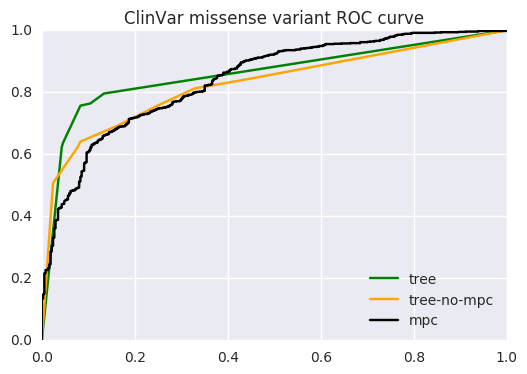

In [102]:
#X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
#preds = tree_clf.predict_proba(X_clin)
#fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, [x[1] for x in preds], pos_label=1)
#tree_auc = metrics.auc(fpr_tree, tpr_tree)
#mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)
print('mpc auc', mpc_auc)
print('tree auc', tree_auc)
print('tree-no-mpc auc', tree_auc_nm)
plt.plot(fpr_tree, tpr_tree, label='tree', color='green')
plt.plot(fpr_tree_nm, tpr_tree_nm, label='tree-no-mpc', color='orange')
plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
plt.legend(loc=4)
plt.title('ClinVar missense variant ROC curve')
plt.savefig('../docs/plots/missense_clinvar_roc_feature_union.png')